# Benchmark Modell 2 with SPG

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../..')
from helper.lazy_regression import TooLazyForRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [2]:
data = pd.read_table('../../data/data_spg.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [4]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_G01,centroid_frequency2_G01,centroid_frequency_G02,centroid_frequency2_G02,median_freq_G01,median_freq_G02,flash_ind_G01,flash_ind_G02,cv_G01,cv_G02,iqa_G01,iqa_G02,mab_G01,mab_G02,imp_G01,imp_G02,len_G01,len_G02
0,36,2.4,2093.635581,1986.847670,1331.195151,852.546891,2021.281643,958.368431,0.002196,0.003504,0.836058,1.065685,2.808968e-07,1.785572e-08,0.021330,0.003658,0,0,37,37
1,29,2.5,1401.125120,1210.376311,1852.769939,1880.745158,1506.211127,1878.700347,0.002212,0.003009,0.984949,1.595162,1.181157e-08,6.594803e-07,0.005302,0.033907,0,2,46,46


In [5]:
data.shape

(52463, 22)

## Select Best Feature for Benchmark

In [20]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [21]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [22]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,0.606936
1,1,0.593029


In [23]:
tmp_ = tmp.groupby('n_feature').mean()

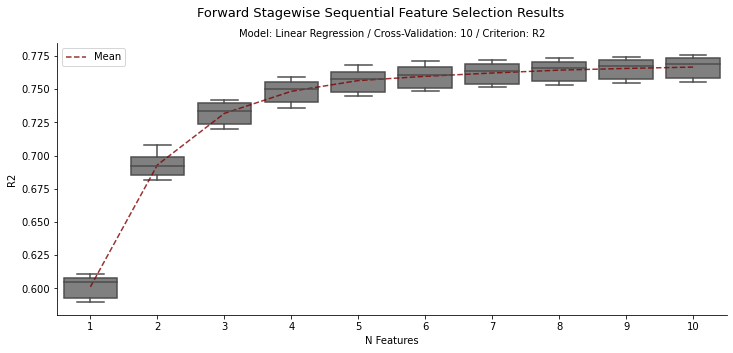

In [24]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [65]:
n_features = 4
best_feature_dict[n_features]

array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_mab_G',
       'max_imp_G'], dtype=object)

In [66]:
X_best = X[best_feature_dict[n_features]]

## Hyperparameter 

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.7540569  0.74908194 0.74471077 0.7553984  0.753966   0.75314603
 0.73986743 0.75170155 0.75135686 0.74049804]
Mean Resutls:  0.7493783936436577


## With Max-Feature

In [6]:
from helper.feature_extract import extract_highest_amplitude_features_with_mp

In [7]:
df_max = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['G01', 'G02']],
                                                  create_one_sensor_feature=True, n_processes=4, 
                                                  keep_columns=False)

INFO || Extracting Max Features for types: ['G01', 'G02']


In [8]:
feature_cols = df_max.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [9]:
X,y = df_max[feature_cols], df_max['size_mm']
X.head(2)

,packnr,velocity,max_centroid_frequency_G,max_centroid_frequency2_G,max_median_freq_G,max_flash_ind_G,max_cv_G,max_iqa_G,max_mab_G,max_imp_G,max_len_G
0,36,2.4,2093.635581,1986.847670,2021.281643,0.002196,0.836058,2.808968e-07,0.021330,0,37
1,29,2.5,1852.769939,1880.745158,1878.700347,0.003009,1.595162,6.594803e-07,0.033907,2,46


In [10]:
df_max.shape

(52463, 13)

In [53]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


In [54]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp_ = tmp.groupby('n_feature').mean()

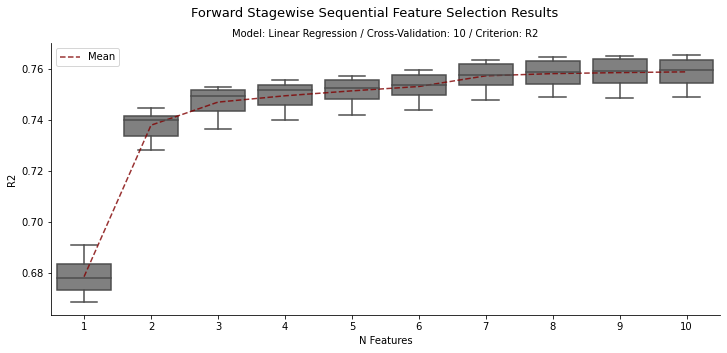

In [55]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [69]:
n_features = 3
best_feature_dict[n_features]

array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_imp_G'],
      dtype=object)

In [70]:
X_best = X[best_feature_dict[n_features]]

In [71]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.75037323 0.7480023  0.74174721 0.75272947 0.75194675 0.75200336
 0.73701453 0.74954223 0.74912934 0.73658604]
Mean Resutls:  0.7469074451081681
